In [ ]:
%pip install -q sentence-transformers==3.0.1 scikit-learn==1.5.1 yfinance fredapi pandas textblob matplotlib seaborn transformers torch

In [1]:
# ===============================
# IMPORTS
# ===============================

# Data handling
import os
import json
import datetime
import time
import re
import warnings
from typing import List, Dict, Any, Optional, Tuple

# Data analysis & numerical computing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display

# Financial & macro data
import yfinance as yf
from fredapi import Fred

# Natural language processing
from textblob import TextBlob
import requests
from bs4 import BeautifulSoup
from transformers import pipeline
import torch
from sentence_transformers import SentenceTransformer

# Machine learning utilities
from sklearn.neighbors import NearestNeighbors

# ===============================
# CONFIGURATION
# ===============================

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Visualization defaults
sns.set_theme()  # Seaborn styling

# ===============================
# FRED API SETUP
# ===============================
FRED_API_KEY = os.environ.get(
    "FRED_API_KEY", "e9b13c9f61d9447309d4c104b82a45d1"
)
fred = Fred(api_key=FRED_API_KEY)

# ===============================
# DIRECTORY CONFIGURATION
# ===============================
CONFIG = {
    "memory_dir": "memory",  # Persistent agent memory
    "report_dir": "reports"  # Directory to save generated charts/reports
}

# Ensure necessary directories exist
os.makedirs(CONFIG["memory_dir"], exist_ok=True)
os.makedirs(CONFIG["report_dir"], exist_ok=True)

# ===============================
# LLM INITIALIZATION
# ===============================
# Use GPU if available, else fallback to CPU
device = 0 if torch.cuda.is_available() else -1

# Summarization pipeline using BART
synthesis_llm = pipeline(
    "summarization",
    model="facebook/bart-large-cnn",
    device=device
)

# ===============================
# SETUP STATUS
# ===============================
print("Setup complete. Configuration directories created/verified.")
print("FRED API initialized.")
print("LLM (BART) initialized for synthesis.")


/opt/anaconda3/envs/dl_final_project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-18 14:53:00.296759: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Device set to use cpu


Setup complete. Configuration directories created/verified.
FRED API initialized.
LLM (BART) initialized for synthesis.


# 🧩 Data Acquisition and Analysis Backbone

This code block encapsulates four key subsystems:

1. **Memory System (Persistent Learning)**

   * Functions `load_memory()` and `save_memory()` maintain *long-term context* by storing and retrieving ticker-specific analysis summaries across runs.
   * This allows the agent to *learn from prior sessions* — a step toward true autonomous improvement.

2. **Dynamic Data Fetching (External Tools)**

   * `fetch_yfinance_data()` integrates with **Yahoo Finance** for historical OHLCV and news.
   * `fetch_fred_data()` integrates with **FRED** for macroeconomic indicators like inflation or GDP.
   * These are examples of **tool-augmented reasoning** — the agent dynamically invokes APIs rather than relying solely on static inputs.

3. **Technical Analysis Tools**

   * `compute_rsi()` computes the **Relative Strength Index**, a core momentum indicator.
   * This supports quantitative reasoning alongside NLP and sentiment cues.

4. **News Impact Analysis (NLP Layer)**

   * `news_impact_analyzer()` performs **lightweight sentiment and tone extraction** on news titles.
   * It uses keyword-based weighting and polarity scoring to estimate whether news coverage is bullish, bearish, or neutral.
   * The results feed downstream agents that interpret context or recommend actions.

Overall, this code is an **Agentic AI foundation** — blending memory, tool-use, reasoning, and language understanding — to autonomously perform **financial signal extraction** and **contextual analysis** in real time.


In [2]:
# ============================================
# DATA HANDLING, FETCHING, AND CORE ANALYSIS FUNCTIONS
# ============================================

# CONFIG and fred are assumed to be initialized globally
# e.g., CONFIG = {"memory_dir": "./memory/"} and fred = Fred(api_key="...")

# --------------------------------------------------
# Persistent learning across runs
# --------------------------------------------------

def load_memory(ticker: str) -> Dict[str, Any]:
    """
    Load a ticker's persistent analysis notes and metadata from disk.

    This function enables *long-term memory* across runs so that 
    the system can incorporate past analyses when re-evaluating a ticker.

    Args:
        ticker (str): Stock ticker symbol (e.g., "AAPL", "TSLA").

    Returns:
        dict: A dictionary containing stored notes and the last run timestamp.
              Defaults to a placeholder if no file exists.
    """
    path = os.path.join(CONFIG["memory_dir"], f"{ticker}.json")
    if os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return {"notes": "No prior analysis", "last_run": None}


def save_memory(ticker: str, data: Dict[str, Any]) -> None:
    """
    Save a ticker's notes or analysis summary for persistent memory.

    Args:
        ticker (str): Stock ticker symbol.
        data (dict): Dictionary containing updated notes, 
                                summaries, or metadata.
    """
    path = os.path.join(CONFIG["memory_dir"], f"{ticker}.json")
    with open(path, "w") as f:
        json.dump(data, f, indent=2)


# --------------------------------------------------
# Data Fetching Tools
# --------------------------------------------------

def fetch_yfinance_data(ticker: str) -> Tuple[pd.DataFrame,
                                              List[Dict[str, Any]]]:
    """
    Fetch 1-year historical OHLCV price data and recent news for a given ticker 
    using the Yahoo Finance API.

    Args:
        ticker (str): Stock ticker symbol.

    Returns:
        Tuple[pd.DataFrame, List[Dict[str, Any]]]: 
            - Historical price data as a DataFrame.
            - List of news articles (may be empty).
    """
    print(f"[Tool Use] Fetching yfinance data for {ticker}...")
    try:
        t = yf.Ticker(ticker)
        hist = t.history(period="1y").reset_index()
        news = t.news or []
        return hist, news
    except Exception as e:
        print(f"[Error] Failed to fetch yfinance data for {ticker}: {e}")
        return pd.DataFrame(), []


def fetch_fred_data(series_id: str) -> pd.DataFrame:
    """
    Fetch a macroeconomic time series (e.g., CPI, unemployment rate) 
    from the Federal Reserve Economic Data (FRED) API.

    Args:
        series_id (str): The FRED series identifier (e.g., "CPIAUCSL").

    Returns:
        pd.DataFrame: Time-indexed economic data with columns 
                    ['date', series_id]. Returns an empty DataFrame 
                    if data is unavailable.
    """
    try:
        s = fred.get_series(series_id)
        if s is None or s.empty:
            return pd.DataFrame()

        df = pd.DataFrame(s).reset_index()
        data_col = df.columns[-1]
        df.rename(columns={data_col: series_id, 'index': 'date'}, inplace=True)
        return df

    except Exception as e:
        print(f"[Error] Failed to fetch FRED data for {series_id}: {e}")
        return pd.DataFrame()


# --------------------------------------------------
# Technical Indicator Computation
# --------------------------------------------------

def compute_rsi(series: pd.Series, window: int = 14) -> pd.Series:
    """
    Compute the Relative Strength Index (RSI) for a price series.

    RSI measures momentum by comparing average gains and losses over a period.

    Args:
        series (pd.Series): Series of closing prices.
        window (int, optional): Lookback period for RSI calculation. 
        Defaults to 14.

    Returns:
        pd.Series: RSI values ranging from 0 to 100.
    """
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rsi = 100 - (100 / (1 + gain / loss))
    return rsi


# --------------------------------------------------
# News Impact Analysis (Prompt Chaining Stage)
# --------------------------------------------------

def news_impact_analyzer(news_list: List[Dict[str, Any]], 
                         ticker: str) -> Tuple[pd.DataFrame, float]:
    """
    Analyze the sentiment and tone of news articles related to a given ticker.

    Combines NLP-based sentiment scoring (via TextBlob) with domain-specific
    heuristics that assign higher weights to impactful keywords or direct
    ticker mentions.

    Args:
        news_list (list): List of news article dictionaries with "title" keys.
        ticker (str): Stock ticker symbol.

    Returns:
        Tuple[pd.DataFrame, float]:
            - DataFrame with columns
            ['title', 'sentiment', 'weighted_sentiment', 'tone']
            - Overall average weighted sentiment score
    """
    results = []
    high_impact_keywords = ["acquire", 
                            "launch",
                            "missed", 
                            "soared", 
                            "failed", 
                            "record", 
                            "major"]

    for n in news_list:
        title = n.get("title", "").lower()
        if not title:
            continue

        sentiment = TextBlob(title).sentiment.polarity
        is_high_impact = any(
            k in title for k in high_impact_keywords) \
                and ticker.lower() in title
        sentiment_weight = 1.0 if is_high_impact else 0.5
        weighted_sentiment = sentiment * sentiment_weight

        tone = (
            "positive" if weighted_sentiment > 0.1
            else "negative" if weighted_sentiment < -0.1
            else "neutral"
        )

        results.append({
            "title": n.get("title", ""),
            "sentiment": round(sentiment, 2),
            "weighted_sentiment": round(weighted_sentiment, 2),
            "tone": tone,
        })

    df = pd.DataFrame(results)
    overall_sentiment = df["weighted_sentiment"].mean(
    ) if not df.empty else 0.0
    return df, overall_sentiment

# 📊 Visualization Layer

Each visualization function acts as a **dynamic tool** that the AI agent can invoke to generate and embed graphical insights into its final reports:

1. **`plot_price_and_rsi()` — Technical Evidence Generator**
   Creates dual-panel charts showing price trends, moving averages, and RSI momentum.
   It helps the agent reason about potential overbought/oversold signals.

2. **`plot_macro_correlation()` — Economic Context Mapper**
   Aligns market data with macroeconomic indicators (like CPI or unemployment)
   to detect correlations that inform macro-sensitive trading or risk analysis.

3. **`plot_sentiment_distribution()` — Media Sentiment Explainer**
   Visualizes the proportion of positive, negative, and neutral news articles —
   contextualizing the agent’s NLP-based sentiment scoring.

Together, these visual tools form the **interpretability substrate** of your Agentic AI system — translating multi-agent reasoning and numeric signals into **intuitive evidence** for end-users, analysts, or downstream automated decision engines.

In [3]:
# ============================================
# VISUALIZATION FUNCTIONS
# ============================================

# --------------------------------------------------
# Price and RSI Visualization
# --------------------------------------------------

def plot_price_and_rsi(
    df: pd.DataFrame,
    ticker: str,
    rsi: pd.Series
) -> Optional[str]:
    """
    Plot a stock's closing price with moving averages and its RSI indicator.

    This visualization provides both trend and momentum evidence 
    to support automated or human interpretation in the analysis report.

    Args:
        df (pd.DataFrame): DataFrame containing columns ['Date', 'Close'].
        ticker (str): Stock ticker symbol (e.g., "AAPL", "GOOGL").
        rsi (pd.Series): Computed RSI values for the corresponding date range.

    Returns:
        Optional[str]: File path to the saved chart image, or None if 
        inputs are empty.
    """
    if df.empty or rsi.empty:
        return None

    plt.style.use("seaborn-v0_8-whitegrid")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # --- Price and Moving Averages ---
    ax1.plot(df["Date"], df["Close"], label="Close",
             color="darkblue", linewidth=1.5)
    ax1.plot(df["Date"], df["Close"].rolling(50).mean(),
             label="MA-50", color="orange", linestyle="--")
    ax1.plot(df["Date"], df["Close"].rolling(200).mean(),
             label="MA-200", color="red", linestyle="--")
    ax1.set_title(f"{ticker} Price and Moving Averages", fontsize=14)
    ax1.legend(loc="upper left")
    ax1.tick_params(axis="y", labelcolor="darkblue")

    # --- RSI Plot ---
    ax2.plot(df["Date"], rsi, label="RSI-14", color="purple", linewidth=1.5)
    ax2.axhline(70, color="red", linestyle="--", alpha=0.7, label="Overbought")
    ax2.axhline(30, color="green", linestyle="--", alpha=0.7, label="Oversold")
    ax2.set_ylim(0, 100)
    ax2.legend(loc="upper left")
    ax2.set_title("RSI Trends", fontsize=14)
    ax2.set_xlabel("Date")

    # --- Save Plot ---
    path = f"{CONFIG['report_dir']}/{ticker}_price_rsi.png"
    plt.tight_layout()
    plt.savefig(path, dpi=100)
    plt.close()

    print(
        f"        [Chart] Generated Price & RSI chart: ",
        f"{os.path.basename(path)}")
    return path


# --------------------------------------------------
# Macro Correlation Visualization
# --------------------------------------------------

def plot_macro_correlation(
    stock_df: pd.DataFrame,
    macro_df: pd.DataFrame,
    ticker: str,
    macro_key: str
) -> Tuple[Optional[str], Optional[float]]:
    """
    Plot and analyze correlation between stock 
    price and a macroeconomic indicator.

    This tool visually aligns time series 
    (e.g., price vs CPI) and computes their 
    Pearson correlation — helping agents 
    infer relationships between 
    market behavior and economic factors.

    Args:
        stock_df: DataFrame with stock price data ('Date', 'Close').
        macro_df: DataFrame with macroeconomic data ('date', macro_key).
        ticker (str): Stock ticker symbol.
        macro_key (str): Column name or FRED series ID for the macro variable.

    Returns:
        Tuple[Optional[str], Optional[float]]:
            - Path to saved chart image (or None if merge fails).
            - Pearson correlation coefficient between price and macro series.
    """
    stock_df_fixed = stock_df.copy()

    # Normalize timezone-aware dates for merging
    if pd.api.types.is_datetime64_any_dtype(stock_df_fixed["Date"]) and \
       stock_df_fixed["Date"].dt.tz is not None:
        stock_df_fixed["Date"] = stock_df_fixed["Date"].dt.tz_localize(None)

    merged = pd.merge(stock_df_fixed, macro_df,
                      left_on="Date", right_on="date", how="inner")
    if merged.empty or len(merged) < 5:
        return None, None

    # Compute correlation
    corr = merged[["Close", macro_key]].corr().iloc[0, 1]

    # --- Plot ---
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.plot(merged["Date"], merged["Close"],
             label=f"{ticker} Close", color="blue")
    ax1.set_xlabel("Date")
    ax1.set_ylabel(f"{ticker} Close Price", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")

    # Twin axis for macro variable
    ax2 = ax1.twinx()
    ax2.plot(merged["date"], merged[macro_key],
             label=macro_key.upper(), color="orange", linestyle="--")
    ax2.set_ylabel(macro_key.upper(), color="orange")
    ax2.tick_params(axis="y", labelcolor="orange")

    # Combined title and legend
    plt.title(
        f"{ticker} vs {macro_key.upper()} (Correlation: {corr:.2f})", 
        fontsize=14)
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="upper left")

    # --- Save Plot ---
    path = f"{CONFIG['report_dir']}/{ticker}_{macro_key}_corr.png"
    plt.tight_layout()
    plt.savefig(path, dpi=100)
    plt.close()

    print(
        f"        [Chart] Generated Macro Correlation chart: ",
        f"{os.path.basename(path)}")
    return path, corr


# --------------------------------------------------
# Sentiment Distribution Visualization
# --------------------------------------------------

def plot_sentiment_distribution(df: pd.DataFrame, ticker: str) -> Optional[str]:
    """
    Visualize the distribution of news article tones for a given ticker.

    This provides interpretability for the NLP-based sentiment analysis stage,
    allowing analysts (or downstream agents) to observe media bias and 
    sentiment concentration.

    Args:
        df (pd.DataFrame): DataFrame containing a 'tone' column with values 
                           such as 'positive', 'negative', or 'neutral'.
        ticker (str): Stock ticker symbol.

    Returns:
        Optional[str]: Path to saved sentiment distribution image, 
        or None if input is empty.
    """
    if df.empty:
        return None

    plt.style.use("seaborn-v0_8-whitegrid")
    plt.figure(figsize=(5, 4))

    # Define bar colors based on tone
    tones = df["tone"].value_counts()
    colors = [
        "green" if t == "positive" else "red" if t == "negative" else "gray"
        for t in tones.index
    ]

    # Plot sentiment counts
    tones.plot(kind="bar", color=colors, alpha=0.7)
    plt.title(f"News Sentiment Distribution ({ticker})", fontsize=14)
    plt.xticks(rotation=0, ha="center")
    plt.ylabel("Number of Articles")
    plt.xlabel("Sentiment Tone")

    # --- Save Plot ---
    path = f"{CONFIG['report_dir']}/{ticker}_sentiment.png"
    plt.tight_layout()
    plt.savefig(path, dpi=100)
    plt.close()

    print(
        f"        [Chart] Generated Sentiment chart: {os.path.basename(path)}")
    return path

# 🧩 Agent Classes

This section defines four specialized agents, each encapsulating a distinct reasoning domain.
Together, they mirror the multi-agent coordination seen in modern agentic financial systems.

| Agent                   | Role                  | Key Capabilities                                                     | Example Outputs                                             |
| ----------------------- | --------------------- | -------------------------------------------------------------------- | ----------------------------------------------------------- |
| **`PriceAnalyzer`**     | Technical analyst     | Computes RSI and classifies short-term trend regime                  | `{ "rsi": 45.7, "regime": "Downtrend" }`                    |
| **`MacroAnalyzer`**     | Macroeconomic analyst | Correlates market behavior with economic indicators (e.g., CPI, GDP) | `{ "corr": 0.63, "plot_path": ".../AAPL_CPI_corr.png" }`    |
| **`NewsAnalyzer`**      | Sentiment analyst     | Extracts tone-weighted sentiment and aggregates polarity             | `{ "sentiment": -0.12, "num_news": 28 }`                    |
| **`NewsSummarizer`**    | Content summarizer    | Fetches, cleans, and generates LLM-based news briefs                 | `"Meta-summary": "Apple announces new product launches..."` |

Each of these acts as a modular tool-using agent, capable of being composed in a higher-order reasoning loop.
In a real deployment, a Coordinator Agent or Orchestrator could dynamically select which specialists to invoke based on goals, data availability, or uncertainty thresholds — embodying autonomous task routing, critique, and refinement.

In [4]:
# ============================================
# SPECIALIST AGENT CLASSES
# ============================================

# --------------------------------------------------
# Price Analyzer Agent
# --------------------------------------------------

class PriceAnalyzer:
    """
    Specialist Agent: Analyzes stock price data to determine RSI and 
    trend regime.

    This agent focuses on technical indicators to assess short-term momentum 
    and overall price direction. It can be invoked autonomously as part of 
    a broader multi-agent workflow.
    """

    def analyze(self, hist: pd.DataFrame) -> Dict[str, Any]:
        """
        Evaluate RSI and classify the current trend as Uptrend or Downtrend.

        Args:
            hist (pd.DataFrame): Historical OHLCV data (must include 'Close').

        Returns:
            dict: Contains RSI value and textual trend regime.
                  Example: {"rsi": 48.7, "regime": "Downtrend"}
        """
        if hist.empty or "Close" not in hist.columns or len(hist) < 20:
            print("        [Warning] PriceAnalyzer received \
                  insufficient historical data.")
            return {"rsi": None, "regime": "N/A (Data Unavailable)"}

        rsi = compute_rsi(hist["Close"])

        if rsi.empty or pd.isna(rsi.iloc[-1]):
            return {"rsi": None, "regime": "N/A (Insufficient Data)"}

        # Compute latest RSI and trend regime (based on 20-day MA)
        rsi_value = rsi.iloc[-1].item()
        ma_20 = hist["Close"].rolling(20).mean().iloc[-1]
        regime = "Uptrend" if hist["Close"].iloc[-1] > ma_20 else "Downtrend"

        return {"rsi": rsi_value, "regime": regime}


# --------------------------------------------------
# Macro Analyzer Agent
# --------------------------------------------------

class MacroAnalyzer:
    """
    Specialist Agent: Analyzes macroeconomic indicators and their correlation 
    with stock performance.

    Typically uses FRED data such as CPI (CPIAUCSL), Unemployment Rate (UNRATE),
    or GDP (GDPC1) to assess the broader economic regime.
    """

    def analyze(
        self, hist: pd.DataFrame, ticker: str, macro_key: str = "CPIAUCSL"
    ) -> Dict[str, Any]:
        """
        Fetch and correlate macroeconomic series with stock price.

        Args:
            hist (pd.DataFrame): Stock historical data with 'Date' and 'Close'.
            ticker (str): Stock ticker symbol.
            macro_key (str, optional): FRED series ID. Defaults to "CPIAUCSL".

        Returns:
            dict: Contains correlation value and chart path.
                  Example: {"corr": 0.62, 
                  "plot_path": "./reports/AAPL_CPIAUCSL_corr.png"}
        """
        macro = fetch_fred_data(macro_key)
        path, corr = plot_macro_correlation(hist, macro, ticker, macro_key)
        return {"corr": corr, "plot_path": path}


# --------------------------------------------------
# News Analyzer Agent
# --------------------------------------------------

class NewsAnalyzer:
    """
    Specialist Agent: Analyzes recent news to determine weighted sentiment 
    and tone.

    Uses the `news_impact_analyzer` tool (sentiment via TextBlob + 
    keyword weighting)
    to produce a structured view of sentiment polarity and coverage breadth.
    """

    def analyze(self, 
                news: list[Dict[str, Any]], 
                ticker: str) -> Dict[str, Any]:
        """
        Evaluate sentiment polarity for a set of news articles.

        Args:
            news (list): List of news article dictionaries from yfinance.
            ticker (str): Stock ticker symbol.

        Returns:
            dict: Includes overall sentiment score, DataFrame of 
            individual results, and number of processed articles.
        """
        df, sentiment = news_impact_analyzer(news, ticker)
        return {"sentiment": sentiment, "news_df": df, "num_news": len(df)}


# --------------------------------------------------
# News Summarizer Agent
# --------------------------------------------------

class NewsSummarizer:
    """
    Specialist Agent: Fetches, cleans, and summarizes news articles for 
    a ticker.

    It combines tool-use (scraping and text cleaning) with 
    LLM-powered summarization 
    to produce concise textual briefs. The resulting summaries serve as a 
    human-readable synthesis for the final report.
    """

    def __init__(self, summarizer: pipeline, ticker: Any):
        """
        Initialize the summarizer agent.

        Args:
            summarizer (pipeline): Hugging Face summarization pipeline instance.
            ticker (Any): Object containing ticker information 
            (e.g., yfinance.Ticker).
        """
        self.summarizer = summarizer
        self.ticker = ticker
        self.content_list: list[str] = []
        self.content_summaries: list[str] = []
        self.meta_summary: Optional[str] = None

    # --------------------------------------------------
    # Ingest & Preprocess — fetch and clean article text
    # --------------------------------------------------
    def fetch_and_clean(self) -> None:
        """
        Fetch and preprocess raw news articles from Yahoo Finance.

        Extracts text content from each linked article, strips HTML tags, 
        normalizes whitespace, and truncates to manageable length 
        for summarization.
        """
        _, news = fetch_yfinance_data(self.ticker.ticker)

        for article in news:
            try:
                response = requests.get(article.get("link", ""), timeout=5)
                soup = BeautifulSoup(response.text, "html.parser")
                text = " ".join(p.get_text() for p in soup.find_all("p"))
                text = re.sub(r"\s+", " ", text).strip()

                if text and len(text) > 50:
                    # truncate for model input
                    self.content_list.append(text[:1000])  

            except Exception:
                continue

    # --------------------------------------------------
    # Summarization — distill multi-article content
    # --------------------------------------------------
    def summarize(self) -> Optional[str]:
        """
        Summarize fetched news articles and produce a consolidated meta-summary.

        Uses the LLM summarization pipeline twice:
          - First pass: summarize each article individually.
          - Second pass: summarize all summaries into a concise meta-summary.

        Returns:
            Optional[str]: Final meta-summary, or None if summarization fails.
        """
        self.fetch_and_clean()

        # Summarize each article
        for content in self.content_list:
            try:
                summary = self.summarizer(
                    content, max_length=60, min_length=20, do_sample=False
                )[0]["summary_text"]
                self.content_summaries.append(summary)
            except Exception:
                continue

        # Generate combined summary if any article summaries exist
        if self.content_summaries:
            combined = " ".join(self.content_summaries)
            try:
                self.meta_summary = self.summarizer(
                    combined, max_length=100, min_length=40, do_sample=False
                )[0]["summary_text"]
            except Exception:
                self.meta_summary = None

        return self.meta_summary


## 🧩 Agent and Prompt Manager

This block defines the *intelligent control layer* that routes prompts, delegates tasks to specialist modules, and synthesizes results via the language model.

---

### 🧠 **`PromptManager`**

**Purpose:**
Acts as a dispatcher — determining whether to analyze a single ticker or compare two tickers, and routing requests accordingly.

**Key responsibilities:**

* Interpret the user’s intent (single-ticker vs pairwise analysis).
* Call appropriate analysis/synthesis methods on the main agent.
* Abstracts the complexity of workflow routing from higher-level scripts or UI layers.

**Core method:**

* `execute_prompt(prompt, ticker=None, ticker2=None)` — handles prompt routing logic.

---

### 🏦 **`InvestmentResearchAgent`**

**Purpose:**
The **autonomous reasoning engine** that coordinates all specialist agents (price, macro, and news analysis), visualization generation, LLM synthesis, and memory updates.

This is the centerpiece of your agentic system.

---

### 🧩 **Internal Specialist Components**

The agent holds and coordinates:

* `PriceAnalyzer` → Technical indicators (RSI, regime).
* `MacroAnalyzer` → Economic correlations (CPI, GDP, etc.).
* `NewsAnalyzer` → Sentiment weighting and aggregation.
* `NewsSummarizer` → Text summarization and meta-summary generation.
* `synthesis_llm` → LLM for report generation.

---

### ⚙️ **Key Methods and Their Roles**

#### 1. `analyze_ticker(ticker)`

Performs the **entire pipeline** for one stock:

* Loads prior notes from memory.
* Fetches data (`fetch_yfinance_data`).
* Runs specialists:

  * Price trend & RSI
  * Macro correlation
  * Sentiment weighting
  * Summarization (via `NewsSummarizer`)
* Generates and displays:

  * RSI chart
  * Macro correlation chart
  * Sentiment distribution chart
* Updates memory with summary and timestamp.

✅ **Output:** A structured result dictionary containing all analysis artifacts and metrics.

---

#### 2. `synthesize_response(prompt, ticker, result)`

**Role:**
Uses the **LLM** to generate a human-readable investment summary and confidence score.

It compiles all numeric and textual analysis into a unified text prompt for the model, enabling reflective synthesis.

It also tries to **extract a confidence score** via regex (e.g., `Confidence: 0.78`), defaulting to 0.5 if not found.

✅ **Output:**
A summary text + confidence float.

---

#### 3. `synthesize_comparison(prompt, ticker1, result1, ticker2, result2)`

**Role:**
Handles **pairwise comparison** workflows.

* Runs both analysis pipelines independently.
* Generates a side-by-side comparison DataFrame.
* Synthesizes a joint narrative summary with confidence.
* Displays supporting visualizations for both tickers.

✅ **Output:**
A comparison text + confidence score.


In [25]:
# AGENT AND PROMPT MANAGER

# Routing workflow — directs request to single‑ticker vs 
# two‑ticker pipelines and downstream specialists
class PromptManager:
    """Manages prompt execution and routing to specialists or LLM."""

    def __init__(self, agent):
        self.agent = agent

    def execute_prompt(self, prompt, ticker=None, ticker2=None):
        print(f"\nProcessing prompt: {prompt}")
        if ticker and ticker2:
            result1 = self.agent.analyze_ticker(ticker)
            result2 = self.agent.analyze_ticker(ticker2)
            self.agent.synthesize_comparison(
                prompt, ticker, result1, ticker2, result2)
        elif ticker:
            result = self.agent.analyze_ticker(ticker)
            self.agent.synthesize_response(prompt, ticker, result)


class InvestmentResearchAgent:
    """Autonomous Investment Research Agent coordinating specialists and LLM."""

    def __init__(self):
        self.price_analyzer = PriceAnalyzer()
        self.macro_analyzer = MacroAnalyzer()
        self.news_analyzer = NewsAnalyzer()
        self.news_summarizer = NewsSummarizer(synthesis_llm, yf.Ticker)
        self.llm = synthesis_llm

# Planning research steps — orchestrates sequence: load memory → 
# fetch data → run specialists → summarize → visualize → persist
    def analyze_ticker(self, ticker):
        """Analyzes a single ticker using specialists."""
        print(f"Analyzing {ticker}...")
        memory = load_memory(ticker)
        print(
            f"    [Agent Learns] Prior Notes ({memory['last_run']}): ", 
            f"{memory['notes']}")
        hist, news = fetch_yfinance_data(ticker)
        price_result = self.price_analyzer.analyze(hist)
        macro_result = self.macro_analyzer.analyze(hist, ticker)
        news_result = self.news_analyzer.analyze(news, ticker)
        sentiment_plot = plot_sentiment_distribution(
            news_result['news_df'], ticker)
        self.news_summarizer.ticker = yf.Ticker(ticker)
        summary = self.news_summarizer.summarize()
        # Generate Price & RSI chart
        rsi = compute_rsi(hist["Close"]) if not hist.empty else pd.Series()
        price_rsi_plot = plot_price_and_rsi(hist, ticker, rsi)
        # Display charts inline
        print(f"============================================================\n"
              f"               📊 Final Investment Report for {ticker}\n"
              f"============================================================\n"
              f"💡 Key Findings:\n"
              f"  - Current RSI (14): {price_result['rsi'] or 'N/A'}", 
              f"Regime: {price_result['regime']}\n"
              f"  - Macro Correlation (CPI): {macro_result['corr'] or 'N/A'}\n"
              f"  - News Sentiment (Weighted): {news_result['sentiment']:.2f}", 
              f"from {news_result['num_news']} articles\n"
              f"\n📝 Agent Metrics & Reflection (Evaluator-Optimizer Output)\n"
              f"  - Data Summary: RSI is {price_result['rsi'] or 'N/A'}, ", 
              f"Trend: {price_result['regime']}. "
              f"CPI Correlation: {macro_result['corr'] or 'N/A'}. ", 
              f"Weighted News Sentiment: {news_result['sentiment']:.2f}.\n")
        print("📈 Visual Evidence:")
        if price_rsi_plot:
            print(f"  Displaying: {os.path.basename(price_rsi_plot)}")
            display(Image(filename=price_rsi_plot))
        if macro_result['plot_path']:
            print(
                f"  Displaying: {os.path.basename(macro_result['plot_path'])}")
            display(Image(filename=macro_result['plot_path']))
        if sentiment_plot:
            print(f"  Displaying: {os.path.basename(sentiment_plot)}")
            display(Image(filename=sentiment_plot))
        print("============================================================\n")
        result = {
            "price": price_result,
            "macro": macro_result,
            "news": news_result,
            "summary": summary,
            "sentiment_plot": sentiment_plot,
            "price_rsi_plot": price_rsi_plot,
            "memory": memory
        }
        save_memory(ticker, {"notes": summary or "No summary",
                    "last_run": str(datetime.datetime.now())})
        return result

# Self‑reflection & Evaluator‑Optimizer — generate analysis, 
# score confidence, use prior notes for feedback/refinement
    def synthesize_response(self, prompt, ticker, result):
        """Generates response using LLM for a single ticker."""
        print(f"SynthesisAgent (LLM) Generating Response...")
        input_text = (
            f"Prompt: {prompt}\n"
            f"Ticker: {ticker}\n"
            f"RSI: {result['price']['rsi'] or 'N/A'}\n"
            f"Price Regime: {result['price']['regime']}\n"
            f"Macro Correlation (CPI): {result['macro']['corr'] or 'N/A'}\n"
            f"News Sentiment: {result['news']['sentiment']:.2f}\n"
            f"News Summary: {result['summary'] or 'No summary'}\n"
            f"Prior Notes: {result['memory']['notes']}\n"
            f"Generate a concise analysis with a confidence " 
            f"score (0-1) and key insights."
        )
        try:
            llm_output = self.llm(input_text, 
                                  max_length=150, 
                                  min_length=50, 
                                  do_sample=False)[0]['summary_text']
            confidence = float(re.search(r'Confidence: (\d\.\d+)', 
                                         llm_output).group(
                1)) if re.search(r'Confidence: (\d\.\d+)', 
                                 llm_output) else 0.5
            print(f"\n============================================================\n"
                  f"             ✨ Final User-Facing Response ✨\n"
                  f"============================================================\n"
                  f"### Comprehensive Summary for {ticker}\n"
                  f"**Agent Confidence:** {confidence}\n\n"
                  f"**Key Analytical Insights:**\n"
                  f"{llm_output}\n"
                  f"\n**Agent Data Conclusion:** *RSI* is "
                  f"{result['price']['rsi'] or 'N/A'}, "
                  f"Trend: {result['price']['regime']}. CPI Correlation: "
                  f"{result['macro']['corr'] or 'N/A'}. "
                  f"Weighted News Sentiment: "
                  f"{result['news']['sentiment']:.2f}.*\n"
                  f"============================================================\n")
            return {"text": llm_output, "confidence": confidence}
        except Exception as e:
            print(f"LLM synthesis failed: {e}")
            return {"text": "Analysis failed", "confidence": 0.5}

# Routing + Evaluator‑Optimizer for pairwise comparison 
# (two specialists pipelines, then LLM synthesis)
    def synthesize_comparison(self, prompt, ticker1, result1, ticker2, result2):
        """Generates comparison using LLM for two tickers."""
        print(f"SynthesisAgent (LLM) Generating Response...")
        input_text = (
            f"Prompt: {prompt}\n"
            f"Ticker 1: {ticker1}\n"
            f"RSI: {result1['price']['rsi'] or 'N/A'}\n"
            f"Price Regime: {result1['price']['regime']}\n"
            f"Macro Correlation (CPI): {result1['macro']['corr'] or 'N/A'}\n"
            f"News Sentiment: {result1['news']['sentiment']:.2f}\n"
            f"News Summary: {result1['summary'] or 'No summary'}\n"
            f"Ticker 2: {ticker2}\n"
            f"RSI: {result2['price']['rsi'] or 'N/A'}\n"
            f"Price Regime: {result2['price']['regime']}\n"
            f"Macro Correlation (CPI): {result2['macro']['corr'] or 'N/A'}\n"
            f"News Sentiment: {result2['news']['sentiment']:.2f}\n"
            f"News Summary: {result2['summary'] or 'No summary'}\n"
            f"Compare the two tickers, provide a confidence score (0-1), \
                and highlight strengths."
        )
        try:
            llm_output = self.llm(input_text, 
                                  max_length=200, 
                                  min_length=80, 
                                  do_sample=False)[
                0]['summary_text']
            confidence = float(re.search(r'Confidence: (\d\.\d+)', llm_output).group(
                1)) if re.search(r'Confidence: (\d\.\d+)', llm_output) else 0.5
            print(f"\n============================================================\n"
                  f"             ✨ Final User-Facing Response ✨\n"
                  f"============================================================\n"
                  f"### Comparative Analysis: {ticker1} vs {ticker2}\n"
                  f"**Query Intent:** Comparison (Address: *{prompt}*)\n")
            display(pd.DataFrame({
                "Metric": ["Agent Confidence", 
                           "RSI (14)", 
                           "Price Regime", 
                           "Macro Corr (CPI)", 
                           "Weighted Sentiment"],
                ticker1: [confidence, result1['price']['rsi'] or 'N/A', 
                          result1['price']['regime'], 
                          result1['macro']['corr'] or 'N/A', 
                          result1['news']['sentiment']],
                ticker2: [confidence,
                          result2['price']['rsi'] or 'N/A', 
                          result2['price']
                    ['regime'], 
                    result2['macro']['corr'] or 'N/A', 
                    result2['news']['sentiment']]
            }))
            print(f"\n**Synthesis Conclusion:**\n{llm_output}\n")

            # Display charts for both tickers
            print("📈 Visual Evidence:")
            if result1['price_rsi_plot']:
                print(
                    f"  Displaying: \
                        {os.path.basename(result1['price_rsi_plot'])}")
                display(Image(filename=result1['price_rsi_plot']))
            if result1['macro']['plot_path']:
                print(
                    f"  Displaying: \
                        {os.path.basename(result1['macro']['plot_path'])}")
                display(Image(filename=result1['macro']['plot_path']))
            if result1['sentiment_plot']:
                print(
                    f"  Displaying: \
                        {os.path.basename(result1['sentiment_plot'])}")
                display(Image(filename=result1['sentiment_plot']))
            if result2['price_rsi_plot']:
                print(
                    f"  Displaying: \
                        {os.path.basename(result2['price_rsi_plot'])}")
                display(Image(filename=result2['price_rsi_plot']))
            if result2['macro']['plot_path']:
                print(
                    f"  Displaying: \
                        {os.path.basename(result2['macro']['plot_path'])}")
                display(Image(filename=result2['macro']['plot_path']))
            if result2['sentiment_plot']:
                print(
                    f"  Displaying: \
                        {os.path.basename(result2['sentiment_plot'])}")
                display(Image(filename=result2['sentiment_plot']))
            print("============================================================\n")
            return {"text": llm_output, "confidence": confidence}
        except Exception as e:
            print(f"LLM comparison failed: {e}")
            return {"text": "Comparison failed", "confidence": 0.5}

# 🧠 RAGStore and Helpers

This section defines a lightweight local Retrieval-Augmented Generation (RAG) system for storing and retrieving text documents using embeddings.

- __RAGStore class__

	- Stores documents (docs.json) and their vector embeddings (embeddings.npy) on disk.

	- Uses a SentenceTransformer (default: "all-MiniLM-L6-v2") to embed text.

	- Supports:

		- upsert() – adds new documents and updates the embedding index.

		- retrieve() – finds the most similar documents to a query using cosine similarity via NearestNeighbors.

	- Automatically reloads saved data on initialization and rebuilds the nearest-neighbor index.

- news_to_rag_docs() helper

	- Converts raw news data into standardized RAG documents (with id, title, text, and metadata).

In [26]:
# RAG Setup
class RAGStore:
    """
    Lightweight local RAG index: stores docs + embeddings on disk and 
    retrieves with cosine similarity.
    Path layout:
      <base_path>/docs.json
      <base_path>/embeddings.npy
    """
    def __init__(self, base_path: str, model_name: str = "all-MiniLM-L6-v2"):
        self.base_path = base_path
        os.makedirs(self.base_path, exist_ok=True)
        self.docs_path = os.path.join(self.base_path, "docs.json")
        self.vecs_path = os.path.join(self.base_path, "embeddings.npy")
        self.model_name = model_name
        self.model = SentenceTransformer(self.model_name)
        self.docs: List[Dict[str, Any]] = []
        self.vecs = None
        self.nn = None
        if os.path.exists(self.docs_path) and os.path.exists(self.vecs_path):
            try:
                with open(self.docs_path, "r", encoding="utf-8") as f:
                    self.docs = json.load(f)
                self.vecs = np.load(self.vecs_path)
                if len(self.docs) == len(self.vecs):
                    self.nn = NearestNeighbors(metric="cosine").fit(self.vecs)
            except Exception:
                self.docs, self.vecs, self.nn = [], None, None

    def _save(self):
        with open(self.docs_path, "w", encoding="utf-8") as f:
            json.dump(self.docs, f, ensure_ascii=False, indent=2)
        if self.vecs is not None:
            np.save(self.vecs_path, self.vecs)

    def upsert(self, docs: List[Dict[str, Any]], 
               text_key: str = "text", id_key: str = "id"):
        existing = {d.get(id_key) for d in self.docs if id_key in d}
        new_docs = [d for d in docs if d.get(id_key) not in existing]
        if not new_docs:
            return 0
        texts = [d.get(text_key, "") or "" for d in new_docs]
        if not any(texts):
            return 0
        new_vecs = self.model.encode(texts, normalize_embeddings=True)
        self.docs.extend(new_docs)
        self.vecs = new_vecs if self.vecs is None \
            else np.vstack([self.vecs, new_vecs])
        self.nn = NearestNeighbors(metric="cosine").fit(self.vecs)
        self._save()
        return len(new_docs)

    def retrieve(self, query: str, k: int = 8):
        if not self.nn or self.vecs is None or not len(self.docs):
            return []
        qv = self.model.encode([query], normalize_embeddings=True)
        k = min(k, len(self.docs))
        dists, idxs = self.nn.kneighbors(qv, n_neighbors=k)
        return [self.docs[i] for i in idxs[0]]

def news_to_rag_docs(news_list: List[Dict[str, Any]], 
                     ticker: str) -> List[Dict[str, Any]]:
    docs = []
    for i, n in enumerate(news_list or []):
        doc_id = n.get("uuid") or n.get("id") \
            or n.get("link") or f"{ticker}-{i}"
        title = n.get("title") or n.get("headline") or "(no title)"
        text = n.get("text") or n.get("content") or n.get("summary") or title
        meta = {
            "ticker": ticker,
            "publisher": n.get("publisher"),
            "published": n.get("providerPublishTime") or n.get("published"),
            "link": n.get("link"),
        }
        docs.append({"id": doc_id, "title": title, 
                     "text": str(text), "meta": meta})
    return docs


## 🗞️ News Summarization with RAG

This block extends the news summarization process to use retrieval-augmented generation (RAG).

- __summarize_news_with_rag()__ function
	
	- Retrieves the top-K relevant news documents for a given ticker from the RAGStore.

	- Builds a context prompt containing summaries or excerpts of these articles.

	- Uses a BART summarization pipeline to generate a focused investor briefing highlighting catalysts, risks, and regulatory issues.

	- Falls back to a provided summarization function if no context is found.

- __NewsSummarizerRAG__ class

	- Inherits from NewsSummarizer (if defined).

	- Overrides the summarize() method to use the RAG-enhanced summarization flow.

	- Provides a fallback version if the base NewsSummarizer is unavailable.

In [27]:
# News Summarizer with RAG
def summarize_news_with_rag(bart_pipeline, 
                            ticker: str, 
                            base_dir: str = "memory", 
                            task: str = "investor briefing", 
                            fallback_fn=None) -> Optional[str]:
    rag = RAGStore(os.path.join(base_dir, ticker, "rag"))
    ctx = rag.retrieve(
        f"{ticker} catalysts guidance regulation litigation \
            product launches earnings macro linkages", k=8)
    if not ctx:
        if callable(fallback_fn):
            return fallback_fn(ticker)
        return None
    context = "\n\n".join(
        [f"[{i+1}] {d['title']}\n{d['text'][:1200]}" for i, d \
         in enumerate(ctx)])
    prompt = (
        f"Summarize recent news for {ticker} for {task}. "
        f"Focus on catalysts, risks, guidance, litigation/regulatory, \
            and timeline. "
        f"Use ONLY the CONTEXT below; be concise.\n\nCONTEXT:\n\
            {context}\n\nBRIEFING:"
    )
    try:
        out = bart_pipeline(prompt, max_length=350, do_sample=False)
        return out[0]["summary_text"]
    except Exception:
        return None


try:
    class NewsSummarizerRAG(NewsSummarizer):

        # Summarize — distills multi‑article content into concise meta‑summary 
		# via LLM
        def summarize(self, ticker: str, *args, **kwargs):
            fb = getattr(super(), "summarize", None)
            return summarize_news_with_rag(self.pipeline, 
                                           ticker, fallback_fn=fb)
except NameError:
    class NewsSummarizerRAG:
        def __init__(self, pipeline):
            self.pipeline = pipeline

        def summarize(self, ticker: str, *_, **__):
            return summarize_news_with_rag(self.pipeline, ticker)

## 💬 Sentiment & Impact Prefiltering with RAG

This section uses the **RAGStore** to prefilter news before sentiment or impact analysis.

* **`prefilter_news_with_rag()`**

  * Queries the RAG index for documents related to key financial topics (e.g., earnings, guidance, lawsuits).
  * Retrieves the most relevant articles per topic while avoiding duplicates.
  * Returns a curated subset of news for downstream analysis.

* **`news_impact_analyzer_rag()`**

  * Uses the RAG-based prefilter to select relevant articles.
  * Falls back to the original news list if the RAG index is empty.
  * Passes the filtered news to a given sentiment or impact analysis function.

In [28]:
# Sentiment / Impact prefilter with RAG
DEFAULT_TOPICS = ["earnings", "guidance", "lawsuit", "regulation", 
                  "M&A", "product", "supply chain"]

def prefilter_news_with_rag(ticker: str, 
                            base_dir: str = "memory", 
                            topics=None, 
                            k_per_topic: int = 3):
    topics = topics or DEFAULT_TOPICS
    rag = RAGStore(os.path.join(base_dir, ticker, "rag"))
    picked = []
    seen = set()
    for t in topics:
        for d in rag.retrieve(f"{ticker} {t}", k=k_per_topic):
            if d["id"] not in seen:
                picked.append(d)
                seen.add(d["id"])
    return picked

def news_impact_analyzer_rag(ticker: str, 
                             original_news_list: list, 
                             analyzer_fn):
    subset = prefilter_news_with_rag(ticker)
    if not subset:
        subset = original_news_list
    return analyzer_fn(subset, ticker)


## 📊 Tiny Macro Knowledge Base (KB)

This block creates a **mini knowledge base** for macroeconomic interpretation and integrates it with the RAG system.

* **Macro KB Setup**

  * Stores predefined explanations (e.g., CPI trends, bond yields, unemployment, yield curve inversion) in a local JSON file (`kb/macro.json`).
  * Automatically initializes the file if it doesn’t exist.

* **`get_macro_explainer()` function**

  * Loads the macro KB into a `RAGStore` for semantic retrieval.
  * Encodes and indexes the macro insights.
  * Retrieves the most relevant explanation for a given query (e.g., “rising CPI and 10Y yield”).

In [29]:
# Tiny Macro KB
MACRO_KB_DIR = "kb"
MACRO_KB_PATH = os.path.join(MACRO_KB_DIR, "macro.json")
os.makedirs(MACRO_KB_DIR, exist_ok=True)

if not os.path.exists(MACRO_KB_PATH):
    _kb = [
        {"id": "cpi_up_bonds_up", "title": "CPI↑ & 10Y↑",
            "text": "Rising inflation and yields often pressure \
                rate‑sensitive equities; value and financials \
                    can sometimes benefit from steeper curves."},
        {"id": "cpi_down_bonds_down", "title": "CPI↓ & 10Y↓",
            "text": "Disinflation with falling yields can support \
                longer‑duration equities; growth names may re‑rate upward."},
        {"id": "unemp_up", "title": "Unemployment↑",
            "text": "Rising unemployment can signal slowing demand; \
                watch consumer discretionary and credit metrics."},
        {"id": "yc_inversion", "title": "Yield curve inversion",
            "text": "Historically associated with recession risk; \
                defensive positioning and quality balance sheets \
                    gain importance."}
    ]
    with open(MACRO_KB_PATH, "w", encoding="utf-8") as f:
        json.dump(_kb, f, ensure_ascii=False, indent=2)


def get_macro_explainer(query: str):
    rag = RAGStore(os.path.join("kb", "macro"))
    try:
        with open(MACRO_KB_PATH, "r", encoding="utf-8") as f:
            items = json.load(f)
        rag.upsert(items, text_key="text", id_key="id")
    except Exception:
        return None
    hits = rag.retrieve(query, k=1)
    return hits[0]["text"] if hits else None

## 📝 Memory RAG for Delta Tracking

This section enables the agent to **track changes in investor briefs** between runs using a local RAG store.

* **`upsert_brief_history()`**

  * Saves a new brief for a ticker into a dedicated RAG store (`memory/<ticker>/history_rag`).
  * Each brief is stored as a document with a unique ID and metadata.

* **`retrieve_prior_brief()`**

  * Retrieves the most relevant prior brief from the RAG store based on semantic similarity.
  * Enables the agent to recall what was previously emphasized in past analyses.

* **`make_delta_paragraph()`**

  * Compares the new brief with the prior one.
  * Extracts lines that are **new** or **no longer emphasized**.
  * Produces a concise summary paragraph highlighting the changes (up to 6 additions/removals each).

In [30]:
# Memory RAG for "what changed since last run" deltas
def upsert_brief_history(ticker: str, 
                         brief_text: str, 
                         base_dir: str = "memory"):
    base = os.path.join(base_dir, ticker, "history_rag")
    rag = RAGStore(base)
    doc = {"id": f"{ticker}-{len(rag.docs)}", "title": f"{ticker} brief",
           "text": brief_text, "meta": {"ticker": ticker}}
    rag.upsert([doc])


def retrieve_prior_brief(ticker: str, 
                         base_dir: str = "memory"):
    base = os.path.join(base_dir, ticker, "history_rag")
    rag = RAGStore(base)
    hits = rag.retrieve(
        f"{ticker} investor brief overview risks catalysts", 
        k=1)
    return hits[0]["text"] if hits else None


def make_delta_paragraph(new_brief: str, 
                         prior_brief: str):
    if not prior_brief:
        return ""
    new_lines = set([l.strip() for l in \
                     new_brief.splitlines() if l.strip()])
    old_lines = set([l.strip() for l in \
                     prior_brief.splitlines() if l.strip()])
    added = list(new_lines - old_lines)[:6]
    removed = list(old_lines - new_lines)[:6]
    parts = []
    if added:
        parts.append("**New since last brief:** " + "; ".join(added))
    if removed:
        parts.append("**No longer emphasized:** " + "; ".join(removed))
    return "\n".join(parts)

## 🔗 RAG Integration with News Fetching

This section connects the RAG pipeline directly to the **news ingestion workflow**:

* **`rag_upsert_after_news_fetch()`**

  * Converts newly fetched news into RAG documents.
  * Inserts them into the ticker’s local RAG store for future retrieval.

* **`NewsAnalyzer.fetch_news`**

  * Wraps the original news fetch method.
  * Automatically updates the RAG store after fetching news.
  * Ensures that all new articles are indexed for semantic retrieval without altering the original workflow.


In [31]:
# Integration
def rag_upsert_after_news_fetch(ticker: str, 
                                news_list: list, 
                                base_dir: str = "memory"):
    if not news_list:
        return 0
    rag = RAGStore(os.path.join(base_dir, ticker, "rag"))
    docs = news_to_rag_docs(news_list, ticker)
    return rag.upsert(docs)

# Connect to NewsAnalyzer
try:
    original_fetch_news = NewsAnalyzer.fetch_news
    def fetch_news_with_rag(self, ticker: str):
        news = original_fetch_news(self, ticker)
        try:
            rag_upsert_after_news_fetch(ticker, news)
        except Exception:
            pass
        return news
    NewsAnalyzer.fetch_news = fetch_news_with_rag
except Exception:
    pass

# 🖥️ Interactive Execution Block

This section provides an **interactive interface** for running the investment research agent in real time.

* **Initialization**

  * Instantiates `InvestmentResearchAgent` and attaches a `PromptManager` for routing prompts to specialists and the LLM.

* **Interactive Examples**

  1. **Summary Analysis** – User enters a ticker; agent generates a comprehensive summary including RSI, macro trends, and news sentiment.
  2. **Risk Assessment** – User enters a ticker; agent analyzes investment risks using price, macro indicators, and news sentiment.
  3. **Comparison Analysis** – User enters two tickers; agent compares performance, risks, and news sentiment side by side.

* **Workflow**

  * Prompts are executed via `PromptManager.execute_prompt()`.
  * Inline charts and text summaries are displayed.
  * Interactive input allows the user to guide the analysis in a notebook environment.


 INVESTMENT AGENT INTERACTIVE MODE 
Please enter the requested ticker symbol in the box       that appears below each instruction.

--- 1. Summary Analysis ---
**TICKER RECEIVED:** AAPL. Running analysis...

Processing prompt: Provide a comprehensive summary of AAPL's recent performance including its RSI, key macro trends, and overall news sentiment.
Analyzing AAPL...
    [Agent Learns] Prior Notes (2025-10-18 15:05:15.619255):  No summary
[Tool Use] Fetching yfinance data for AAPL...
        [Chart] Generated Macro Correlation chart:  AAPL_CPIAUCSL_corr.png
[Tool Use] Fetching yfinance data for AAPL...
        [Chart] Generated Price & RSI chart:  AAPL_price_rsi.png
               📊 Final Investment Report for AAPL
💡 Key Findings:
  - Current RSI (14): 46.468641114105246 Regime: Downtrend
  - Macro Correlation (CPI): -0.8345954491547297
  - News Sentiment (Weighted): 0.00 from 0 articles

📝 Agent Metrics & Reflection (Evaluator-Optimizer Output)
  - Data Summary: RSI is 46.4686411141

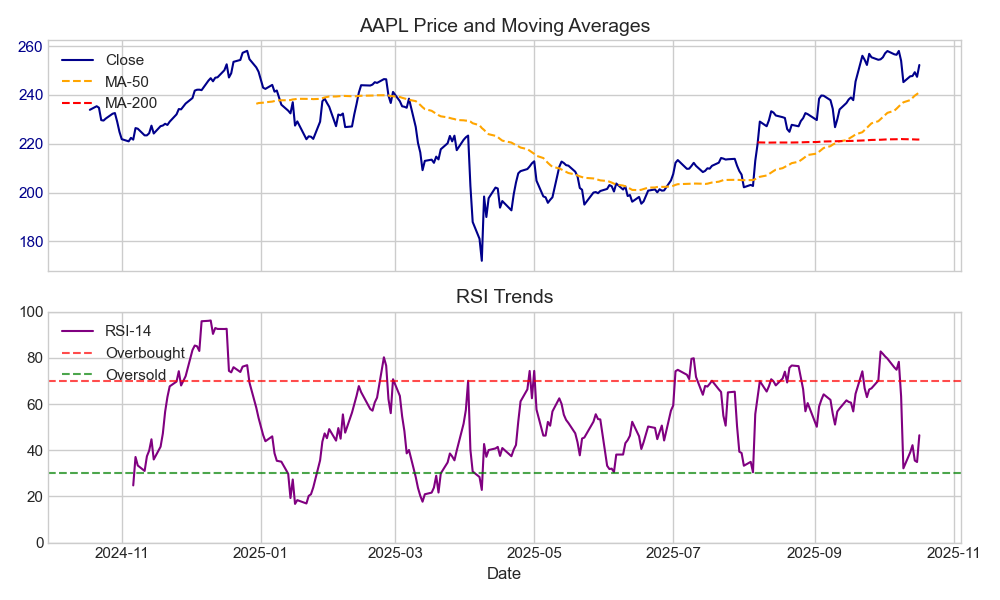

  Displaying: AAPL_CPIAUCSL_corr.png


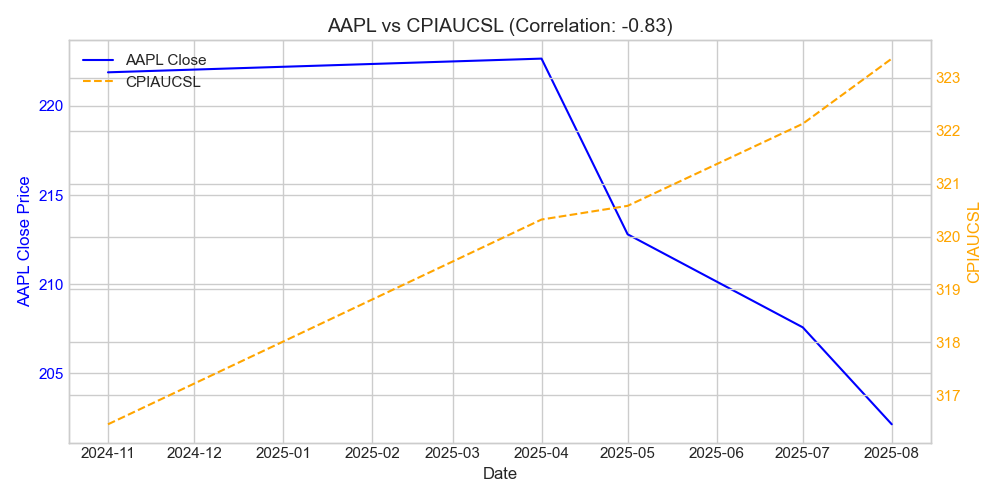

Your max_length is set to 150, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)



SynthesisAgent (LLM) Generating Response...

             ✨ Final User-Facing Response ✨
### Comprehensive Summary for AAPL
**Agent Confidence:** 0.5

**Key Analytical Insights:**
AAPL's RSI is 46.468641114105246. Price Regime: Downtrend. Macro Correlation (CPI): -0.8345954491547297. News Sentiment: 0.00.

**Agent Data Conclusion:** *RSI* is 46.468641114105246, Trend: Downtrend. CPI Correlation: -0.8345954491547297. Weighted News Sentiment: 0.00.*


--- 2. Risk Assessment Analysis ---
**TICKER RECEIVED:** TSLA. Running analysis...

Processing prompt: Analyze the investment risk for TSLA based on current price trends, relevant macro indicators like CPI, and prevailing news sentiment. Highlight any red flags.
Analyzing TSLA...
    [Agent Learns] Prior Notes (2025-10-18 15:05:03.636355):  No summary
[Tool Use] Fetching yfinance data for TSLA...
        [Chart] Generated Macro Correlation chart:  TSLA_CPIAUCSL_corr.png
[Tool Use] Fetching yfinance data for TSLA...
        [Chart] Generate

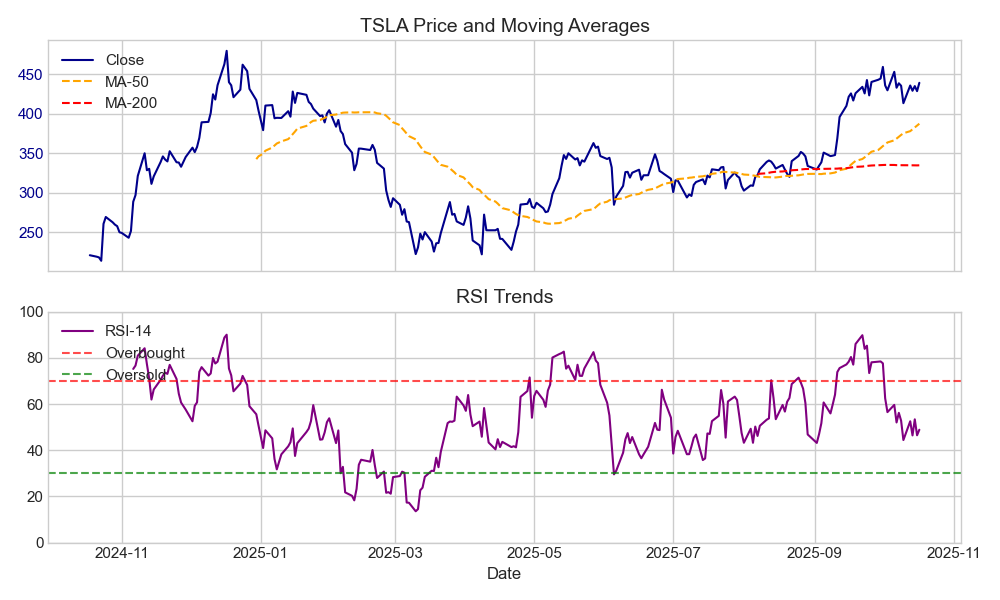

  Displaying: TSLA_CPIAUCSL_corr.png


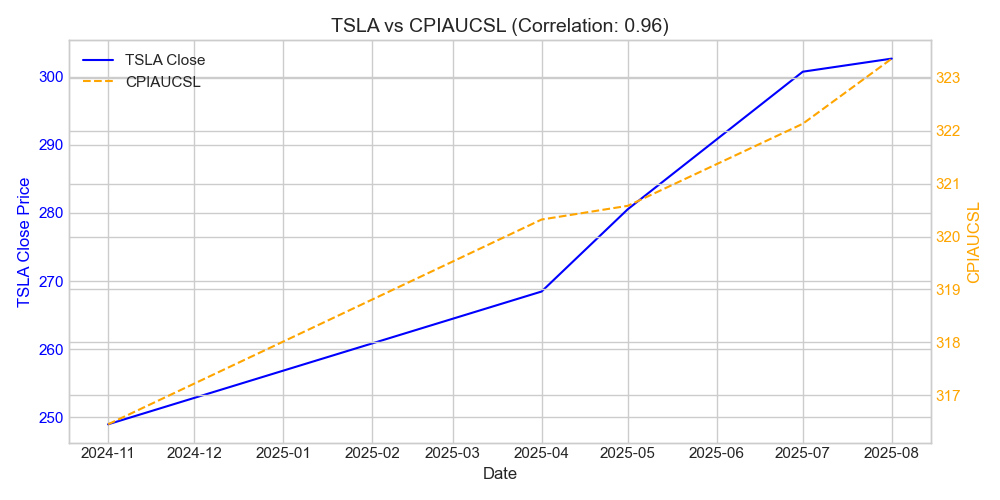

Your max_length is set to 150, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)



SynthesisAgent (LLM) Generating Response...

             ✨ Final User-Facing Response ✨
### Comprehensive Summary for TSLA
**Agent Confidence:** 0.5

**Key Analytical Insights:**
Analyze the investment risk for TSLA based on current price trends, relevant macro indicators like CPI, and prevailing news sentiment. Highlight any red flags.Generate a concise analysis with a confidence score (0-1) and key insights.

**Agent Data Conclusion:** *RSI* is 48.86759787199315, Trend: Uptrend. CPI Correlation: 0.9599051620109236. Weighted News Sentiment: 0.00.*


--- 3. Comparison Analysis ---
**TICKERS RECEIVED:** AAPL and           MSFT. Running comparison...

Processing prompt: Compare AAPL against MSFT focusing on their investment performance, recent risks, and how news sentiment differs between them.
Analyzing AAPL...
    [Agent Learns] Prior Notes (2025-10-18 15:07:15.222871):  No summary
[Tool Use] Fetching yfinance data for AAPL...
        [Chart] Generated Macro Correlation chart:  AAPL_

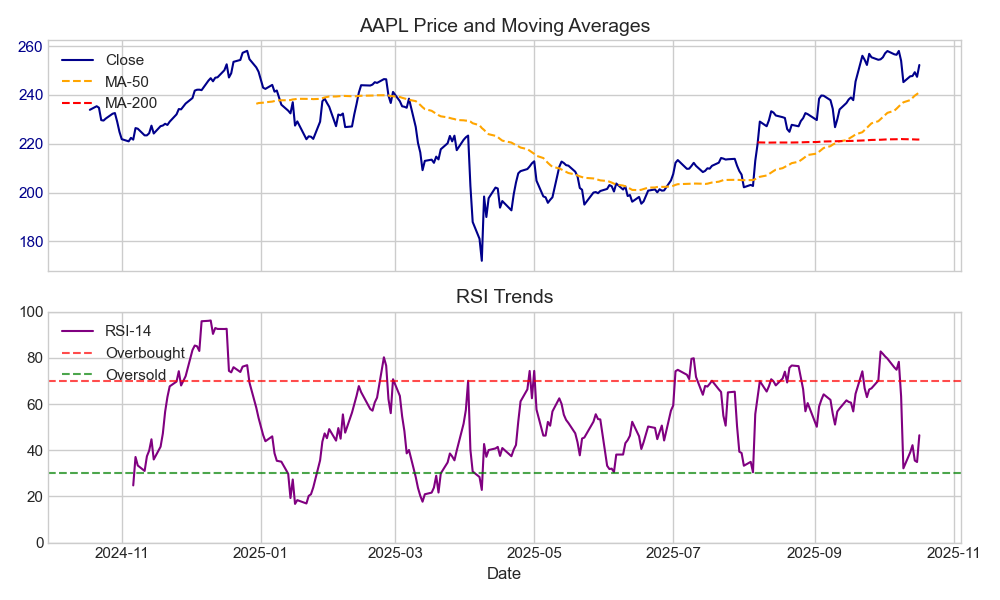

  Displaying: AAPL_CPIAUCSL_corr.png


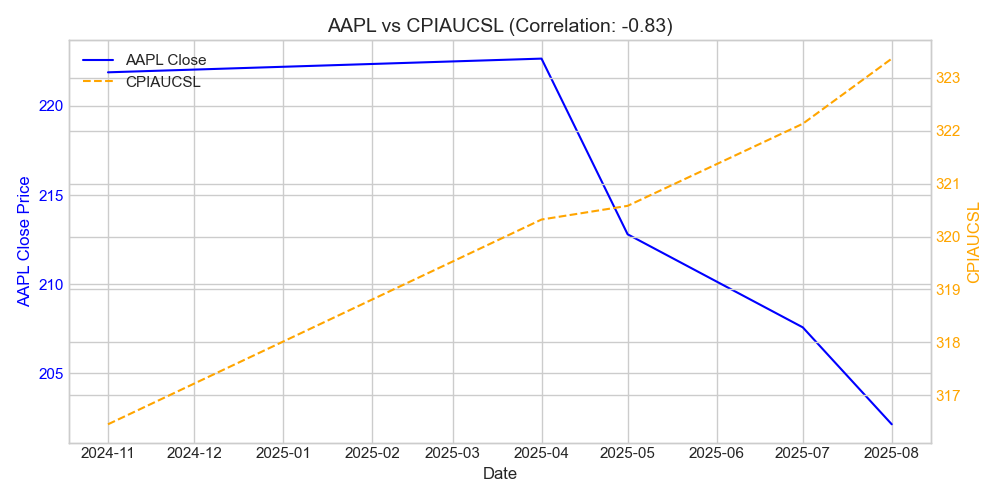


Analyzing MSFT...
    [Agent Learns] Prior Notes (2025-10-18 15:05:17.144485):  No summary
[Tool Use] Fetching yfinance data for MSFT...
        [Chart] Generated Macro Correlation chart:  MSFT_CPIAUCSL_corr.png
[Tool Use] Fetching yfinance data for MSFT...
        [Chart] Generated Price & RSI chart:  MSFT_price_rsi.png
               📊 Final Investment Report for MSFT
💡 Key Findings:
  - Current RSI (14): 48.95410609273413 Regime: Downtrend
  - Macro Correlation (CPI): 0.741019899418371
  - News Sentiment (Weighted): 0.00 from 0 articles

📝 Agent Metrics & Reflection (Evaluator-Optimizer Output)
  - Data Summary: RSI is 48.95410609273413,  Trend: Downtrend. CPI Correlation: 0.741019899418371.  Weighted News Sentiment: 0.00.

📈 Visual Evidence:
  Displaying: MSFT_price_rsi.png


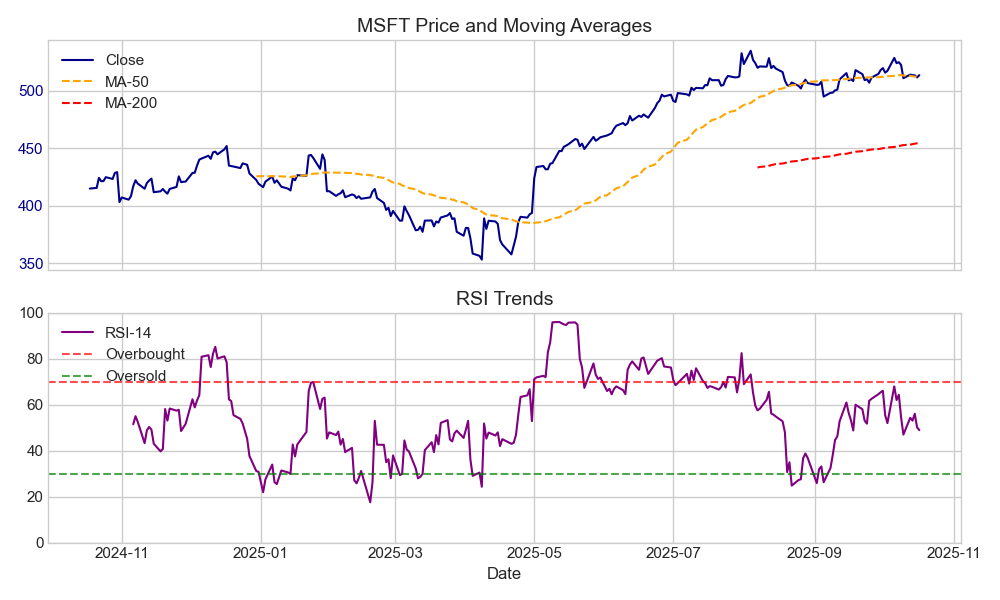

  Displaying: MSFT_CPIAUCSL_corr.png


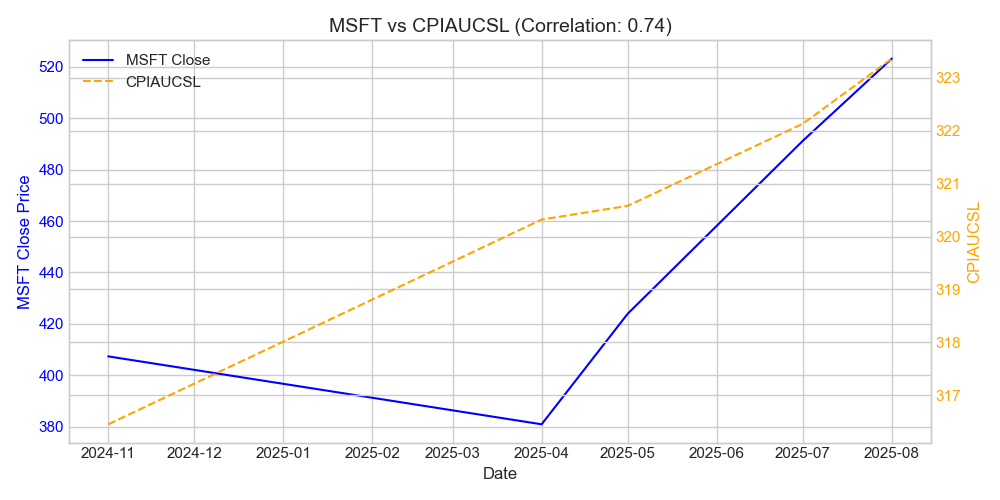

Your max_length is set to 200, but your input_length is only 181. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)



SynthesisAgent (LLM) Generating Response...

             ✨ Final User-Facing Response ✨
### Comparative Analysis: AAPL vs MSFT
**Query Intent:** Comparison (Address: *Compare AAPL against MSFT focusing on their investment performance, recent risks, and how news sentiment differs between them.*)



,Metric,AAPL,MSFT
0,Agent Confidence,0.5,0.5
1,RSI (14),46.468641,48.954106
2,Price Regime,Downtrend,Downtrend
3,Macro Corr (CPI),-0.834596,0.74102
4,Weighted Sentiment,0.0,0.0



**Synthesis Conclusion:**
Compare the two tickers, provide a confidence score (0-1), and highlight strengths. Prompt: Compare AAPL against MSFT focusing on their investment performance, recent risks, and how news sentiment differs between them. The results will be published at the bottom of the page. For confidential support call the Samaritans on 08457 90 90 90, visit a local Samaritans branch or see www.samaritans.org.

📈 Visual Evidence:
  Displaying:                         AAPL_price_rsi.png


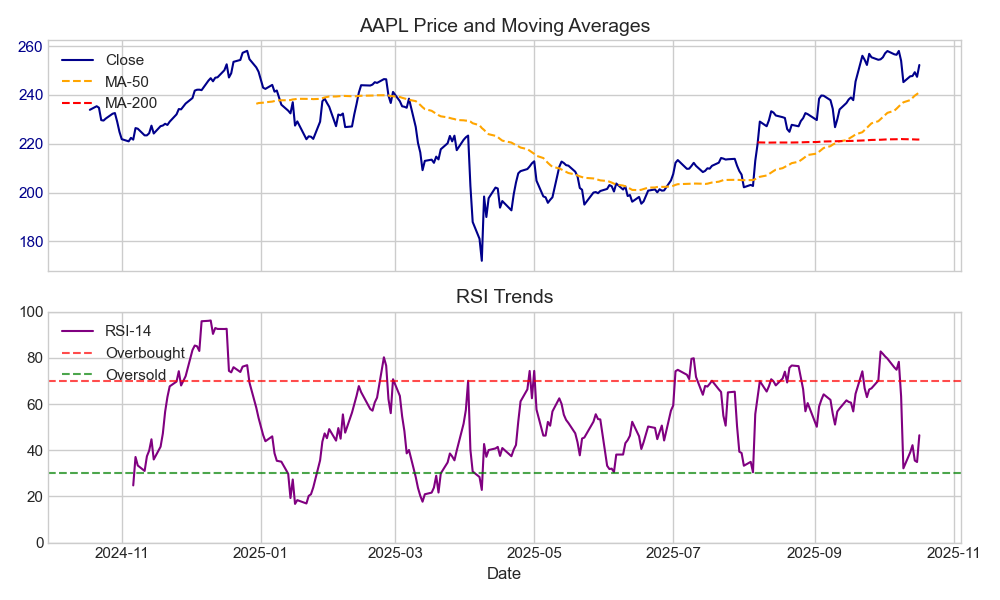

  Displaying:                         AAPL_CPIAUCSL_corr.png


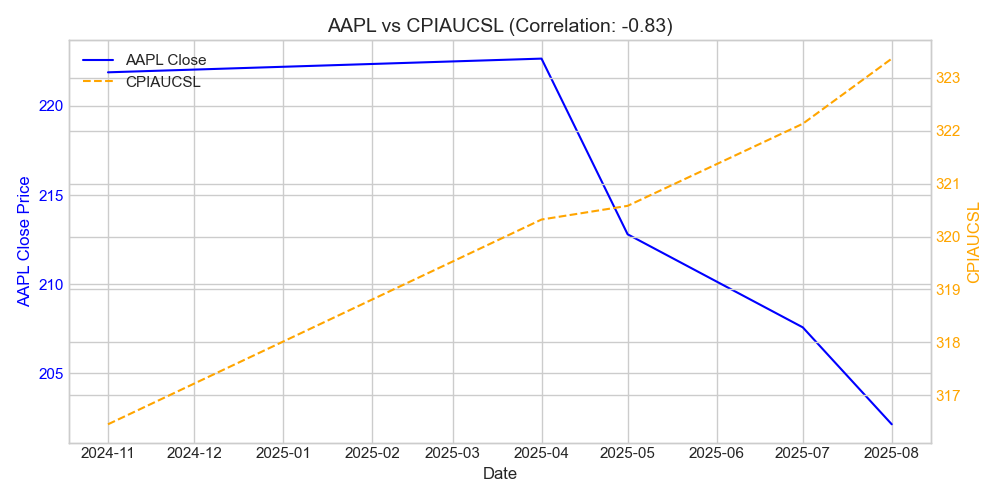

  Displaying:                         MSFT_price_rsi.png


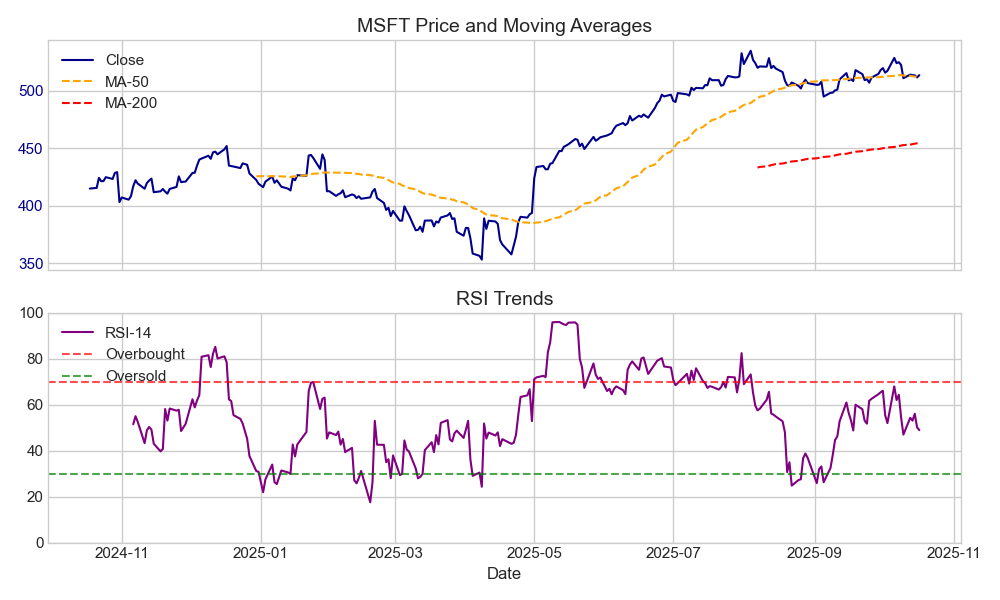

  Displaying:                         MSFT_CPIAUCSL_corr.png


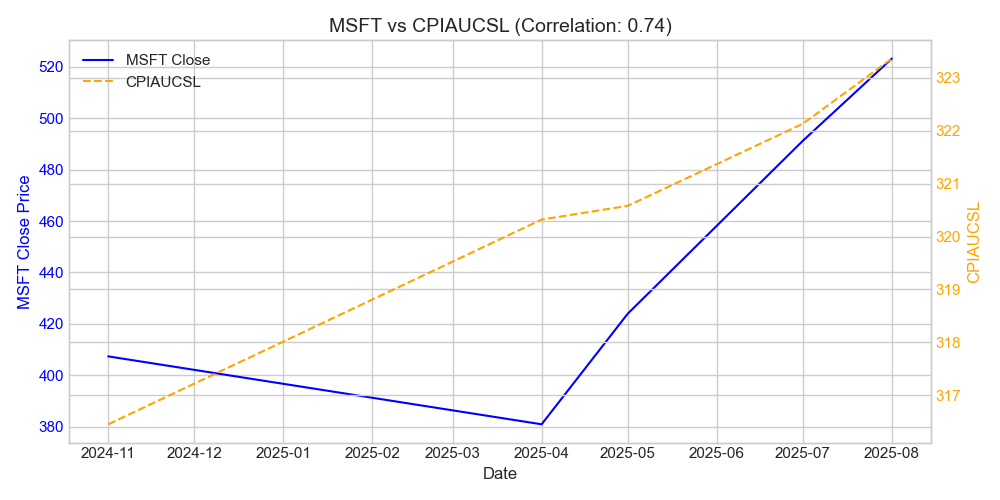



 INTERACTIVE MODE ENDED 


In [33]:
# INTERACTIVE EXECUTION BLOCK

# Initialize the InvestmentResearchAgent
agent = InvestmentResearchAgent()

# Attach a PromptManager
agent.prompt_manager = PromptManager(agent)

print("\n" + "="*70)
print(" INVESTMENT AGENT INTERACTIVE MODE ")
print("Please enter the requested ticker symbol in the box \
      that appears below each instruction.")
print("="*70)

# Interactive Example 1: Summary
print("\n--- 1. Summary Analysis ---")
user_ticker_summary = input("Enter Ticker for Summary (e.g., AAPL): ").upper()
if user_ticker_summary:
    print(f"**TICKER RECEIVED:** {user_ticker_summary}. Running analysis...")
    agent.prompt_manager.execute_prompt(
        (f"Provide a comprehensive summary of {user_ticker_summary}'s recent "
        "performance including its RSI, key macro trends, "
        "and overall news sentiment."),
        ticker=user_ticker_summary
    )
    time.sleep(1)

# Interactive Example 2: Risk Assessment
print("\n--- 2. Risk Assessment Analysis ---")
user_ticker_risk = input("Enter Ticker for Risk Assessment (e.g., TSLA): ").upper()
if user_ticker_risk:
    print(f"**TICKER RECEIVED:** {user_ticker_risk}. Running analysis...")
    agent.prompt_manager.execute_prompt(
        (f"Analyze the investment risk for {user_ticker_risk} "
            "based on current price trends, relevant macro indicators "
            "like CPI, and prevailing news sentiment. "
            "Highlight any red flags."),
        ticker=user_ticker_risk
    )
    time.sleep(1)

# Interactive Example 3: Comparison
print("\n--- 3. Comparison Analysis ---")
user_ticker1_comp = input("Enter FIRST Ticker for Comparison \
                          (e.g., AAPL): ").upper()
user_ticker2_comp = input("Enter SECOND Ticker for Comparison \
                          (e.g., MSFT): ").upper()
if user_ticker1_comp and user_ticker2_comp:
    print(f"**TICKERS RECEIVED:** {user_ticker1_comp} and \
          {user_ticker2_comp}. Running comparison...")
    agent.prompt_manager.execute_prompt(
        (f"Compare {user_ticker1_comp} against {user_ticker2_comp} focusing "
        "on their investment performance, recent risks, and how news "
        "sentiment differs between them."),
        ticker=user_ticker1_comp,  # Corrected from ticker1 to ticker
        ticker2=user_ticker2_comp
    )

print("\n" + "="*40)
print(" INTERACTIVE MODE ENDED ")
print("="*40)

# System Analysis

This investment research agent system is a sophisticated multiagent framework designed to integrate financial data, macroeconomic indicators, and textual information such as news articles and summaries. It combines analytical computation with natural language understanding, effectively merging quantitative finance with modern NLP techniques. The architecture reflects a hybrid reasoning system that blends statistical, symbolic, and generative AI.

The **data acquisition layer** collects structured market data through APIs such as Yahoo Finance, macroeconomic indicators from the Federal Reserve Economic Data (FRED) database, and unstructured text data via web scraping. This integration is a key source of information that the system uses to contextualize its research assignments.

The **analytical layer** consists of several specialized modules: `PriceAnalyzer`, `MacroAnalyzer`, `NewsAnalyzer`, and `NewsSummarizer`. Each module functions as a domain-specific “tool agent.” The **PriceAnalyzer** computes technical indicators like the Relative Strength Index (RSI) and detects trend regimes; the **MacroAnalyzer** correlates stock performance with macroeconomic variables; the **NewsAnalyzer** quantifies sentiment; and the **NewsSummarizer** distills large volumes of text into concise insights using a transformer-based summarization model. This modular decomposition greatly enhances maintainability, interpretability, and scalability. However, analytical depth could be expanded to include additional financial metrics such as volatility, Sharpe ratios, or drawdown statistics for a more holistic analysis.

A core innovation in the design is the **Retrieval-Augmented Generation (RAG) system**, which allows the model to draw upon stored contextual information when producing summaries or insights. This lightweight RAG implementation uses a local vector database constructed with Sentence Transformers and cosine similarity search, enabling the model to efficiently recall relevant documents or historical data. While this approach is elegant and efficient for local use, it lacks persistence and scalability. Transitioning to a dedicated vector database backend such as FAISS could significantly improve retrieval quality and performance.

The **visualization and reporting layer** translates complex analyses into clear, investor-friendly outputs. By combining price charts, macro correlations, and sentiment summaries, this layer provides interpretable and actionable insights.

The **execution and interaction layer** is designed around command-line and notebook interactivity, enabling users to manually initiate analyses, generate summaries, and explore contextual insights. This design is ideal for experimentation, research, and educational demonstrations. However, it could be enhanced with automation features for batch processing or scheduled report generation, allowing the system to scale for institutional or multi-asset analysis.

While the system is functionally robust and well-structured, several areas could be improved to enhance its reliability, analytical capability, and user experience.

For example, data handling could be made more resilient by introducing asynchronous fetching, retry logic, and caching mechanisms to handle network interruptions or API limits gracefully.

Analytical depth can be expanded to better capture market complexity, and prompt management could be upgraded to better handle free-form input.

RAG and knowledge management could be improved by moving away from a file-based storage system to a persistent vector database would enable faster and more accurate retrieval across larger datasets. Additionally, incorporating metadata such as timestamps, topics, and entity tags could help filter and rank context more effectively, while recency-weighted retrieval could ensure that financial analyses remain time-relevant.

Finally, agent autonomy and system memory could be improved by enabling the system to maintain context between sessions. This would allow it to track trends over time, self-assess previous conclusions, and refine its reasoning using retrieved historical insights. Introducing confidence scoring for each module (e.g., RSI, sentiment, macro correlation) could also make the agent’s decision-making more transparent and interpretable.